# Загрузка данных

In [1]:
%matplotlib inline

In [2]:
import vk
import time
import requests
import json
from tqdm import tqdm_notebook
import networkx as nx
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community.quality import modularity

In [3]:
token='0eb712aca84a3f208aea72c5618b800548329f38842210ade528280798c7fee50e9f34cb32fc27c54e928'

session = vk.Session(access_token = token)
api = vk.API(session)

group = 'polina_still_alive'

In [4]:
group_followers = api.groups.getMembers(group_id = group, sort='id_asc', v="5.92")
group_number_followers=group_followers['count']
group_id_followers=group_followers['items']
not_closed_ids=[]

In [5]:
group_followers

{'count': 4, 'items': [82605916, 98872821, 141893055, 164756088]}

In [6]:
common_friends_temp=dict()
group_data=dict()
for i in group_id_followers:
    user_info=api.users.get(user_id = i, fields = 'is_closed, sex, bdate, city, country, universities, schools', v ="5.89")
    if user_info[0]['is_closed'] == False:
        group_data[i] = user_info[0]
        common_friends_temp[i]=api.friends.get(user_id=i,fields='sex, bdate, city, country, universities, schools',v="5.89")['items']
        not_closed_ids.append(i)
    time.sleep(1)

In [7]:
common_friends_open =[]#друзья друзей, которые не члены группы и чьи профили открыты
common_friends_close =[]
for key in common_friends_temp:
    for friend in common_friends_temp[key]:
        if 'is_closed' in friend: #может быть удаленный пользователь без этого поля
            if friend['is_closed']==False:
                if (friend['id'] not in not_closed_ids) and (friend['id'] not in common_friends_open):
                    common_friends_open.append(friend['id'])
            else:
                common_friends_close.append(friend['id'])

**обработка данных:**

In [9]:
def break_list(l): #разбиение списка на списки по 100 элем и обьединение этих списков в список списков
    length_100=len(l)//100
    res=[]
    coun=0
    rem=len(l)-100*length_100
    for i in range (0,length_100):
        res.append([])
        for j in range(0,100):
            res[i].append(l[coun])
            coun=coun+1
        print(res)
    if rem!=0:
        res.append([])
        for j in range(0,rem):
            res[length_100].append(l[coun])
            coun=coun+1
    return res

In [10]:
frbrf=dict()
for fr in common_friends_open:
    frbrf[fr]=[]
broke=break_list(not_closed_ids)
for key in tqdm_notebook(frbrf):
    for i in range(0,len(broke)):
        try:
            beta=api.friends.getMutual(source_uid=key, target_uids=broke[i],v='5.89')
            frbrf[key]=beta
            time.sleep(0.6)
        except requests.exceptions.ReadTimeout:
            print("Переподключение к серверам ВК")
            time.sleep(3)
            beta=api.friends.getMutual(source_uid=key, target_uids=broke[i],v='5.89')
            frbrf[key]=beta
            time.sleep(0.6)
frbrf_cl=dict()
for key in frbrf:
    frbrf_cl[key]=[]
    for user in frbrf[key]:
        if user['common_friends']!=[]:
            for elem in user['common_friends']:
                frbrf_cl[key].append(elem)
central_relat=dict()
for key in common_friends_temp:
    central_relat[key]=[]
    for i in common_friends_temp[key]:
        central_relat[key].append(i['id'])

<ipython-input-10-d22556b6a9a1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key in tqdm_notebook(frbrf):


**сохранение в файл:**

In [11]:
with open('group_data.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
    fh.write(json.dumps(group_data, ensure_ascii=False))
with open('common_friends_temp.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
    fh.write(json.dumps(common_friends_temp, ensure_ascii=False))
with open('frbfr_cl.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
    fh.write(json.dumps(frbrf_cl, ensure_ascii=False))
with open('central_relat.json', 'w', encoding='utf-8') as fh: #открываем файл на запись
    fh.write(json.dumps(central_relat, ensure_ascii=False))

# Построение графа

In [12]:
g = nx.Graph()
g.add_nodes_from((fid, {'sex': friend.get('sex', '-1'), 
                        'first_name': friend.get('first_name', '-1'), 
                        'last_name': friend.get('last_name', '-1'),
                        'city_name': friend.get('city_name', '-1'),
                        'country_name': friend.get('country_name', '-1'),
                        'faculty_name': friend.get('faculty_name', '-1'),
                        'age': friend.get('age', -1),
                        'university_name': friend.get('university_name', '-1')}) for fid, friend in group_data.items())

In [13]:
for key in central_relat:
    if central_relat[key]!=[]:
        for j in central_relat[key]:
            g.add_edge(key,j)
for key in frbrf_cl:
    if frbrf_cl[key]!=[]:
        for j in frbrf_cl[key]:
            g.add_edge(key,j)
remove = [node for node,degree in dict(g.degree()).items() if degree < 1]
g.remove_nodes_from(remove)

In [14]:
g.number_of_edges()

6460

In [15]:
g.number_of_nodes()

851

In [16]:
nx.write_graphml(g, 'us.graphml')

In [17]:
# Uncomment if you are using colab
# !mkdir ./data
# !mkdir ./data/1504653

# !wget https://github.com/TanasevichPS/DZ/blob/main/central_relat.json
# !wget https://github.com/TanasevichPS/DZ/blob/main/common_friends_temp.json
# !wget https://github.com/TanasevichPS/DZ/blob/main/frbfr_cl.json
# !wget https://github.com/TanasevichPS/DZ/blob/main/group_data.json

# Визуализация

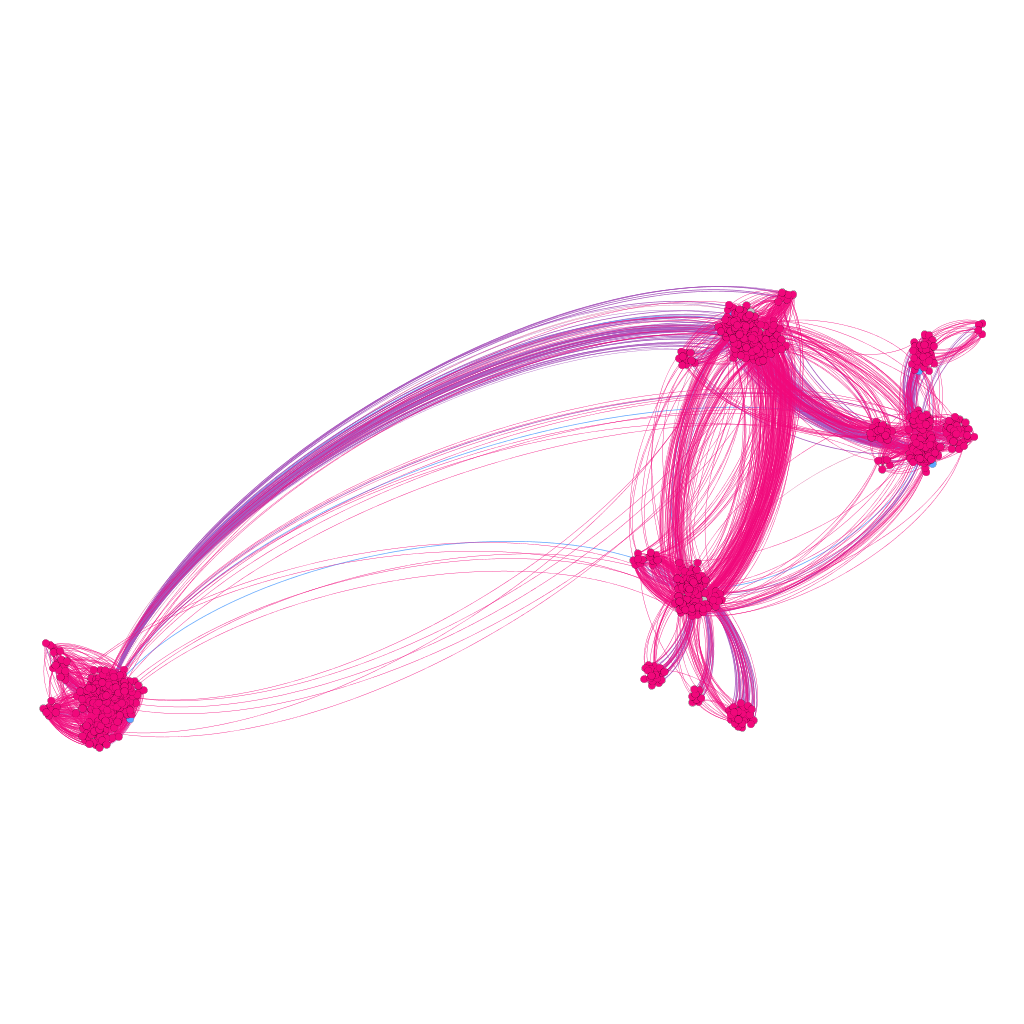

In [18]:
from IPython.display import Image
Image("pic1.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic1.png

# Центральности вершин

In [56]:
def keywithmaxval(d): 
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]
def key_min(d): 
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(min(v))]

In [57]:
degr_cent = nx.centrality.degree_centrality(g)
closeness_nodes = nx.centrality.closeness_centrality(g)
betw_nodes = nx.betweenness_centrality(g) 

In [58]:
print('Максимальные значения')
print('degree: ', keywithmaxval(degr_cent))
m1=keywithmaxval(degr_cent)
print(degr_cent[m1])
print('closeness centrality: ', keywithmaxval(closeness_nodes))
m2=keywithmaxval(closeness_nodes)
print(closeness_nodes[m2])
print('betweenes centrality: ',keywithmaxval(betw_nodes))
m3=keywithmaxval(betw_nodes)
print(betw_nodes[m3])

Максимальные значения
degree:  82605916
0.3988235294117647
closeness centrality:  82605916
0.6245407788390889
betweenes centrality:  82605916
0.5385134509626598


**затупустить одну из ячеек в зависимости от того, что нужно: 1 - degree; 2 - closeness; 3 - betweenness centrality**

**итог записывается в файл analytics**

In [59]:
g1=g.copy()
numnod=g.number_of_nodes()
part=int(numnod/3)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='others'
for i in range(0,part):
    mm=key_min(degr_cent)
    degr_cent.pop(mm,-1)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='top 66%'
for i in range(0,part):
    mm=key_min(degr_cent)
    degr_cent.pop(mm,-1)
for key in degr_cent:
    g1.nodes[key]['deg_cent']='top 33%'
g1.nodes[m1]['deg_cent']='best'

In [60]:
nx.write_graphml(g1, 'analytics_deg.graphml')

In [24]:
for key in closeness_nodes:
    g1.nodes[key]['closeness']='others'
for i in range(0,part):
    mm=key_min(closeness_nodes)
    closeness_nodes.pop(mm,-1)
for key in closeness_nodes:
    g1.nodes[key]['closeness']='top 66%'
for i in range(0,part):
    mm=key_min(closeness_nodes)
    closeness_nodes.pop(mm,-1)
for key in closeness_nodes:
    g1.nodes[key]['closeness']='top 33%'
g1.nodes[m2]['closeness']='best'

In [ ]:
nx.write_graphml(g1, 'analytics_clos.graphml')

In [25]:
for key in betw_nodes:
    g1.nodes[key]['betw']='others'
for i in range(0,part):
    mm=key_min(betw_nodes)
    betw_nodes.pop(mm,-1)
for key in betw_nodes:
    g1.nodes[key]['betw']='top 66%'
for i in range(0,part):
    mm=key_min(betw_nodes)
    betw_nodes.pop(mm,-1)
for key in betw_nodes:
    g1.nodes[key]['betw']='top 33%'
g1.nodes[m3]['betw']='best'

In [26]:
nx.write_graphml(g1, 'analytics_betw.graphml')
#!wget https://github.com/TanasevichPS/DZ/blob/main/analytics_deg.graphml
#!wget https://github.com/TanasevichPS/DZ/blob/main/analytics_clos.graphml
#!wget https://github.com/TanasevichPS/DZ/blob/main/analytics_betw.graphml

# Визуализация наиболее влиятельных вершины 

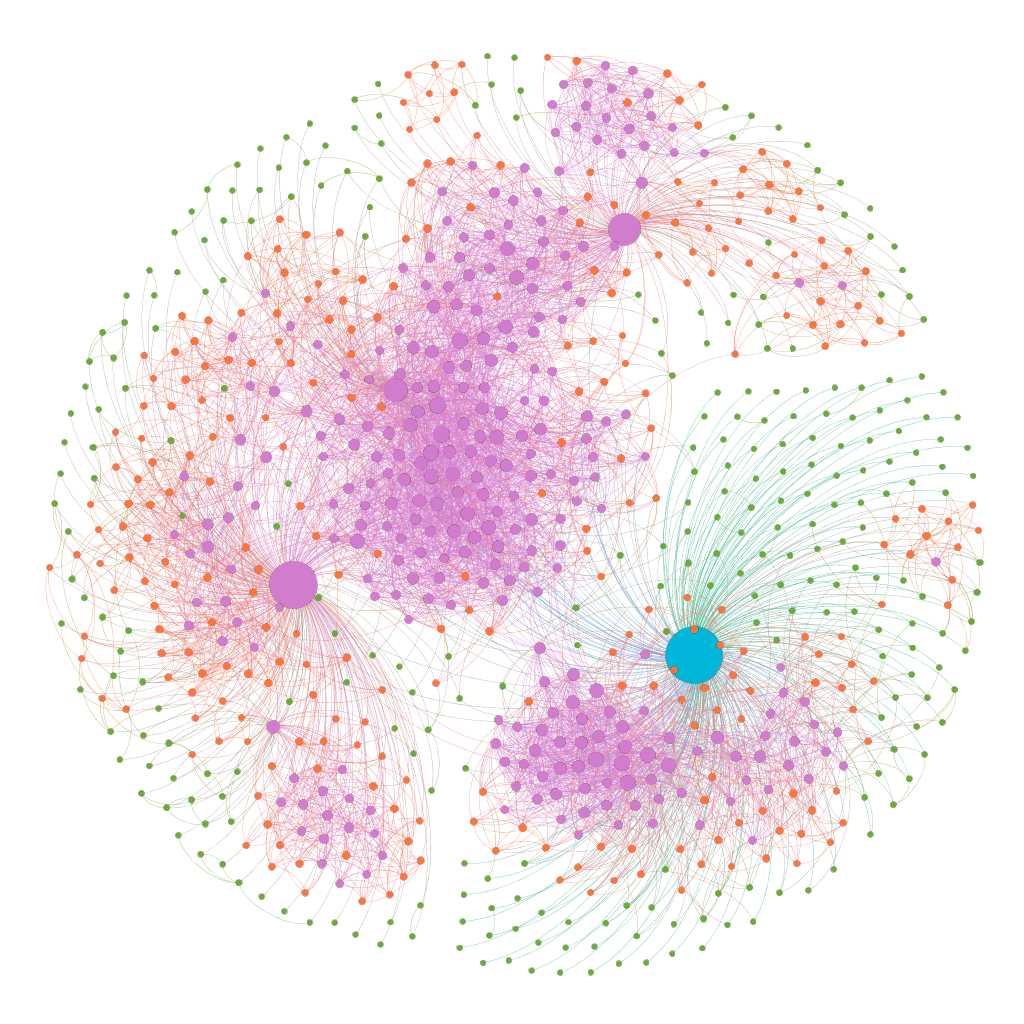

In [27]:
Image("pic2_deg.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic2_deg.png
#others - зеленый
#top 66% - оранжевый
#top 33% - фиолетовый
#best - голубой

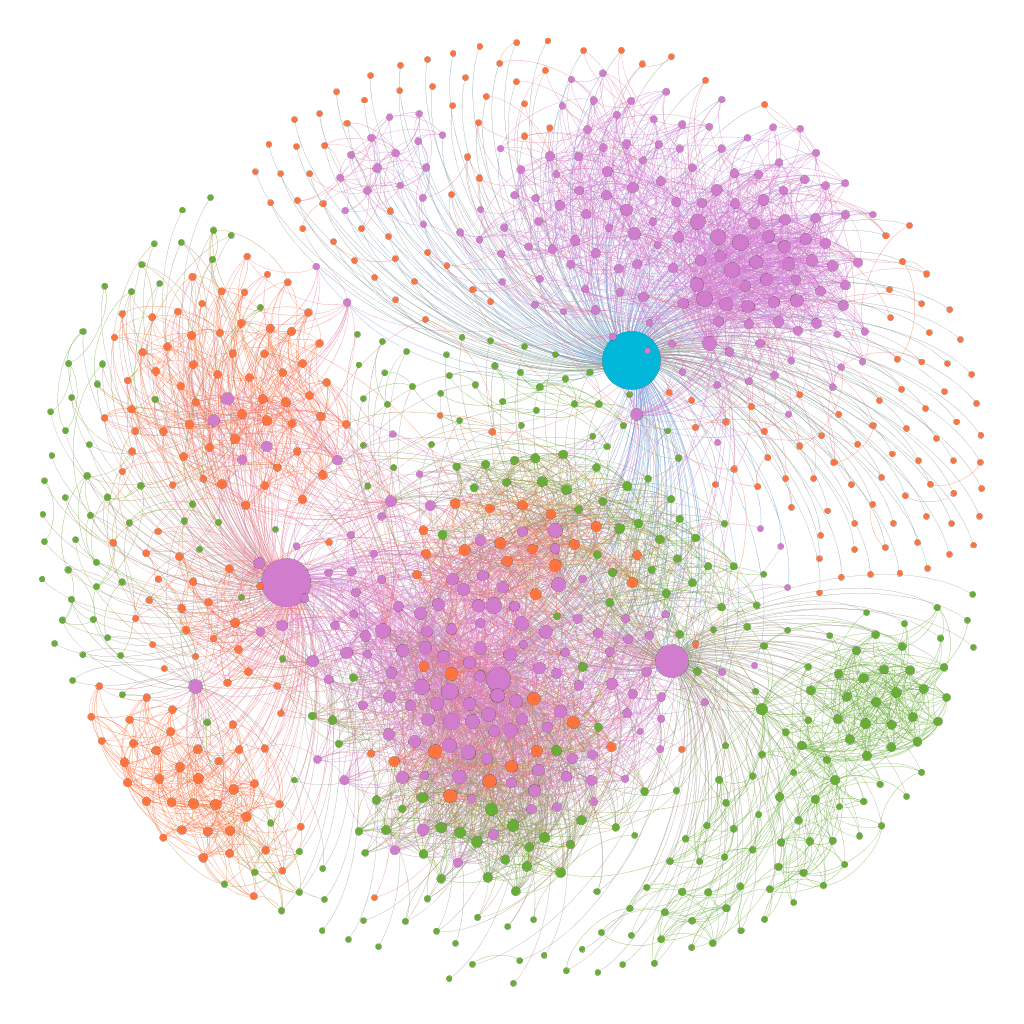

In [28]:
Image("pic2_clos.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic2_clos.png
#others - зеленый
#top 66% - оранжевый
#top 33% - фиолетовый
#best - голубой

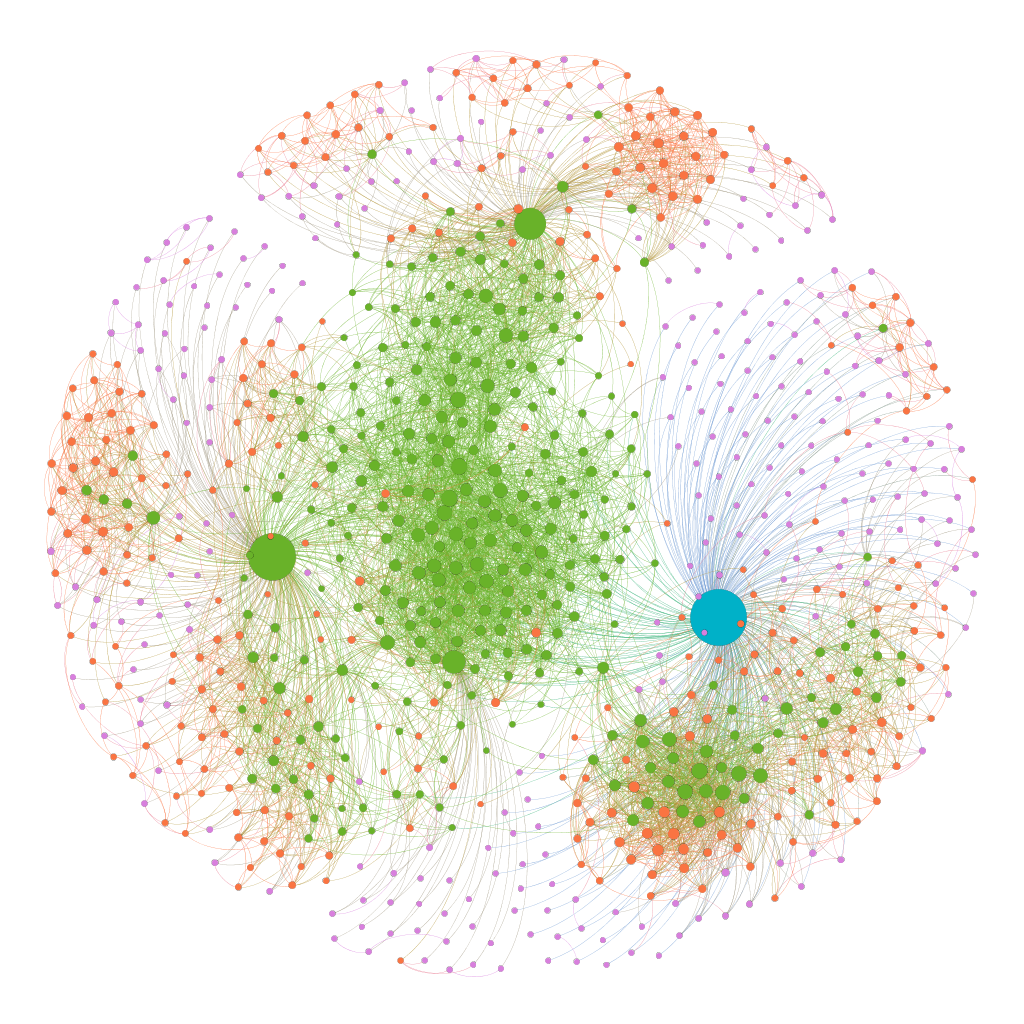

In [29]:
Image("pic2_betw.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic2_betw.png
#others - фиолетовый
#top 66% - оранжевый
#top 33% - зеленый
#best - голубой

# Сообщества в сообществе

# jaccard

In [30]:
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

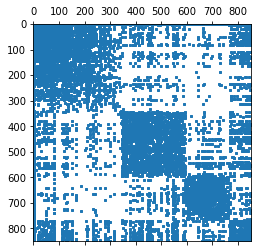

In [31]:
p=g.copy()
p1 = nx.Graph()
pp = nx.disjoint_union(p1, p)
A = nx.adj_matrix(pp)
plt.spy(A, markersize=2)

In [32]:
jac = nx.jaccard_coefficient(pp)
jac = np.array(list(jac))
size=pp.number_of_nodes()

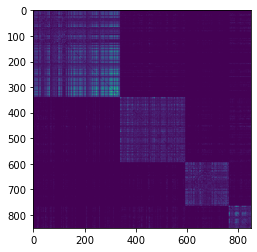

In [36]:
from scipy.sparse import coo_matrix
B = coo_matrix((jac[:,2], (jac[:,0], jac[:,1])), shape=(size,size))
B = B+B.T
plt.imshow(B.toarray())

In [37]:
model = SpectralClustering(n_clusters=11, affinity='rbf')
model.fit(B)

C:\Users\Public\12\lib\site-packages\sklearn\cluster\_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


SpectralClustering(n_clusters=11)

In [38]:
labels = model.labels_
label1=[]
for j in labels:
    label1.append(j)
for i in range(0,size):
    pp.nodes[i]['jacar']=label1[i]

In [39]:
from networkx.algorithms.community.quality import modularity
def marks(labels):
    a=[]
    for i in labels:
        if i not in a:
            a.append(i)
    return a
def make_commun(labels):
    res=dict()
    helper=marks(labels)
    for mark in helper:
        res[mark]=set()
    hh=0
    for i in labels:
        res[i].add(hh)
        hh=hh+1
    result=[]
    for key in res:
        result.append(res[key])
    return result

In [40]:
best=[]
for i in tqdm_notebook(range(2,16)):
    model = SpectralClustering(n_clusters=i, affinity='precomputed')
    model.fit(D)
    labels = model.labels_
    beta=make_commun(labels)
    b1=modularity(pp,beta)
    best.append(b1)

<ipython-input-40-b091e3da0331>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(2,16)):


In [46]:
max_best=max(best)
best_num=best.index(max_best)+2
#print(max_best)
#print(best_num)

In [42]:
model = SpectralClustering(n_clusters=best_num, affinity='precomputed')
model.fit(D)
labels = model.labels_
label1=[]
for j in labels:
    label1.append(j)
for i in range(0,size):
    pp.nodes[i]['jacar']=label1[i]

In [44]:
nx.write_graphml(pp, 'jacar.graphml')
#!wget https://github.com/TanasevichPS/DZ/blob/main/jacar.graphml

# Визуализация графа с вершинами, раскрашенными в цвет своего сообщества

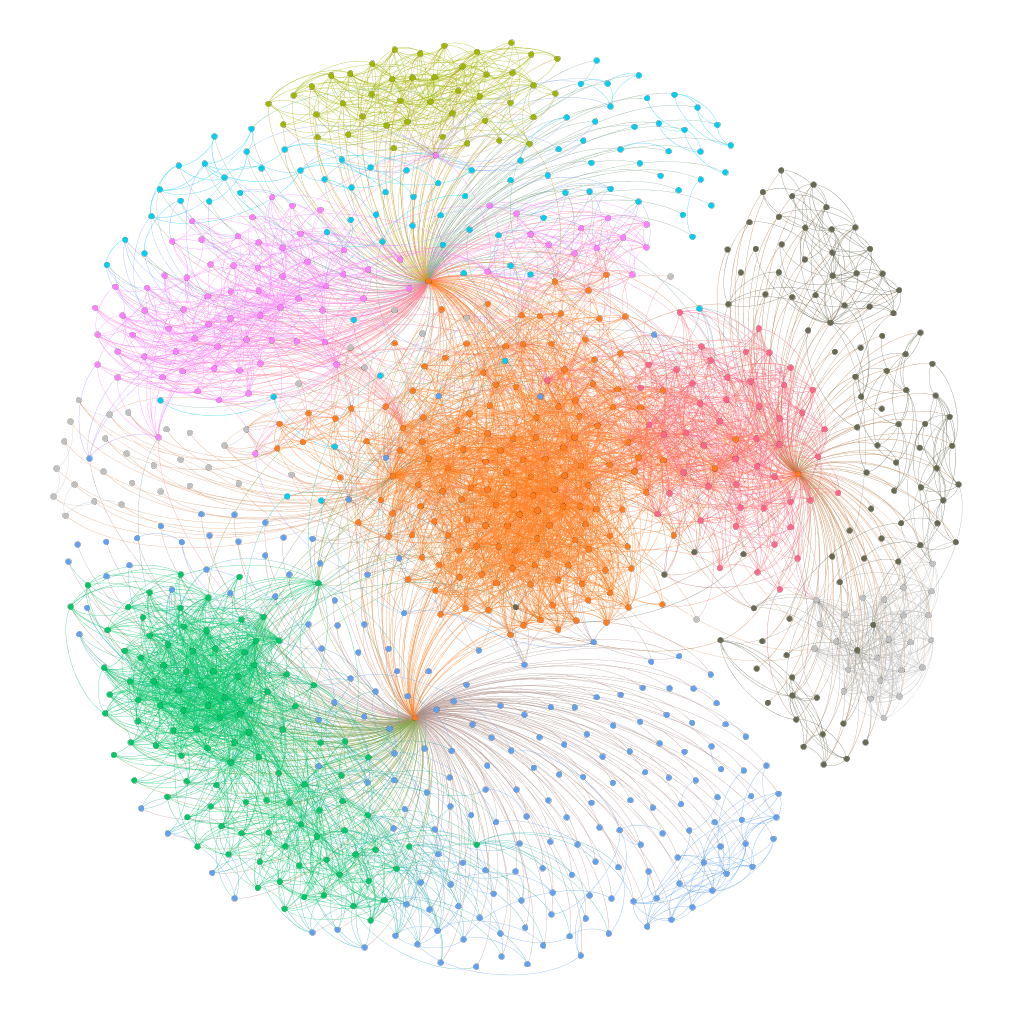

In [45]:
Image("pic3.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic3.png

# Label propagation

In [47]:
qq=g.copy()

In [48]:
def get_labeling_from_partition(partition):
    all_nodes = set()
    for cluster in partition:
        all_nodes |= cluster
    num_nodes = len(all_nodes)
    labeling = dict()
    for label, ids in enumerate(partition):
        ids = list(ids)
        for i in ids:
            labeling[i] = label    
    return labeling
def to_form(lp_labeling):
   a=[]
   for key in lp_labeling:
      if lp_labeling[key] not in a:
         a.append(lp_labeling[key])
   final=dict()
   for i in a:
      final[i]=set()
   for key in lp_labeling:
      final[lp_labeling[key]].add(key)
   resik=[]
   for key in final:
      resik.append(final[key])
   return resik

In [49]:
best=[]
for i in tqdm_notebook(range(0,3)):
    lp_partition = nx.community.asyn_lpa_communities(qq,seed=i)
    lp_partition = list(lp_partition)
    lp_labeling = get_labeling_from_partition(lp_partition)
    res=to_form(lp_labeling)
    b1=modularity(qq,res)
    best.append(b1)  

<ipython-input-49-fca91ee28f72>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0,3)):


In [52]:
max_best=max(best)
best_num=best.index(max_best)
#print(max_best)
#print(best_num) 

In [51]:
lp_partition = nx.community.asyn_lpa_communities(qq,seed=best_num)
lp_partition = list(lp_partition)
lp_labeling = get_labeling_from_partition(lp_partition)
for key in lp_labeling:
    qq.nodes[key]['propagation']=lp_labeling[key]

In [53]:
nx.write_graphml(qq, 'labeprop.graphml')
#!wget https://github.com/TanasevichPS/DZ/blob/main/labeprop.graphml

# Визуализация графа с вершинами, раскрашенными в цвет своего сообщества

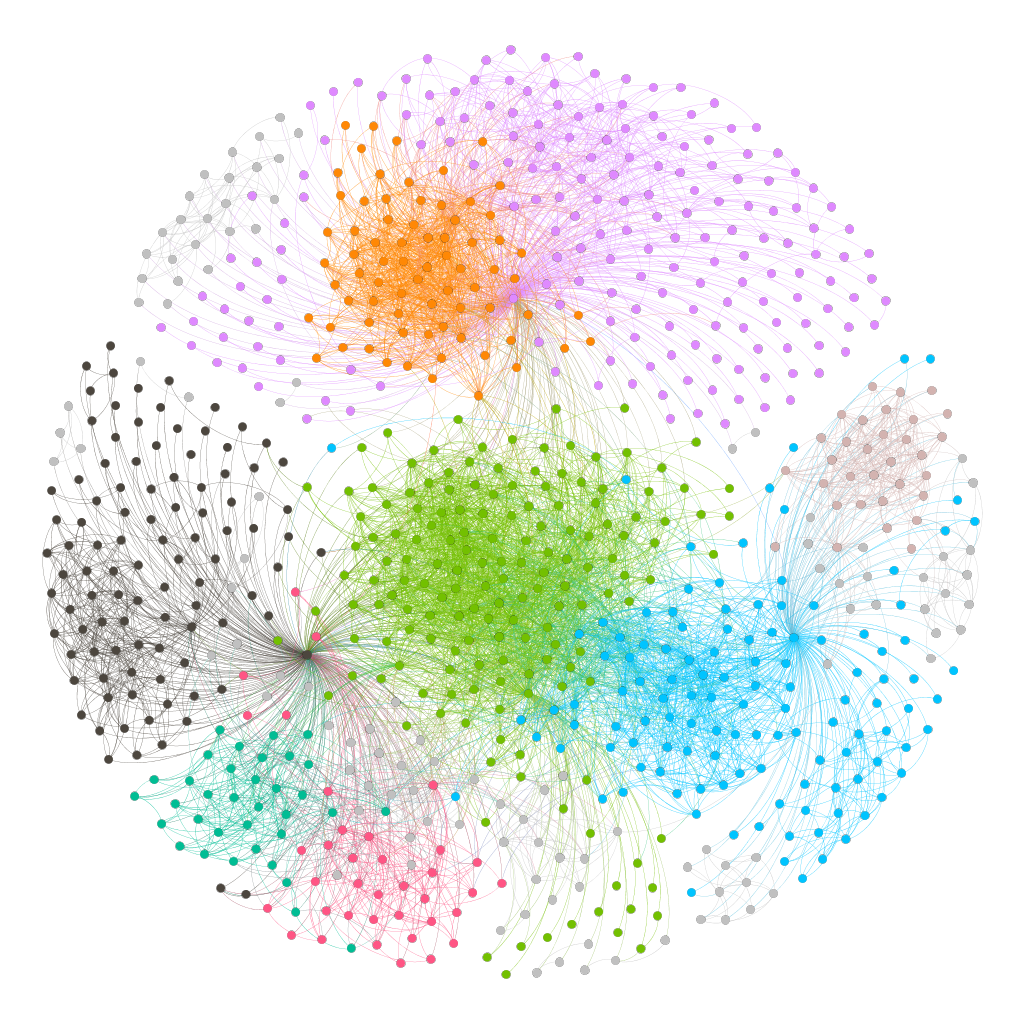

In [54]:
Image("pic4.png")
#!wget https://github.com/TanasevichPS/DZ/blob/main/pic4.png